
## Test

### Background


If you run this notebook in SageMaker Studio, you need to make sure ipywidgets is installed and restart the kernel, so please uncomment the code in the next cell, and run it.

In [2]:
%%capture
import IPython
import sys

!{sys.executable} -m pip install ipywidgets
IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

In [2]:
!python -m pip install --upgrade pip --quiet
!pip install -U awscli --quiet
!pip install -U sagemaker --quiet

In [3]:
import logging

# This code will be loaded on each worker separately..
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [4]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
import boto3
import datetime
import time
from time import strftime,gmtime
import json
import os
import urllib
import sys
import io

role = get_execution_role()
boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
region = boto_session.region_name
bucket = sm_session.default_bucket()
prefix = 'async-inference-maskrcnn'

print(region)
print(role)
print(bucket)
print(prefix)

us-east-1
arn:aws:iam::438093652407:role/TeamRole
sagemaker-us-east-1-438093652407
async-inference-maskrcnn


Create an endpoint config name. Here we create one based on the date so it we can search endpoints based on creation time.

In [5]:
endpoint_name = "sm-2023-03-11-14-53-24"

In [28]:
import json
import base64

with open("data/input/venus-of-milo-512.jpg", "rb") as image2string:
        base64_bytes  = base64.b64encode(image2string.read())

# pass it as string for json
base64_string = base64_bytes.decode('utf-8')
    

model_inputs = {'prompt': "Turn her to a cyborg",
            'image': base64_string,
            'steps': 20,
            'image_cfg_scale': 1.3,
            'text_cfg_scale': 7,
            'num_images_per_prompt': 1,
}
request_body = {"model_inputs": model_inputs}
payload = json.dumps(request_body, indent=2)

In [29]:
%%time
ep= endpoint_name
sm_runtime = boto3.Session().client('sagemaker-runtime')
r = sm_runtime.invoke_endpoint(EndpointName=ep, Body=payload)

CPU times: user 64.8 ms, sys: 9.96 ms, total: 74.7 ms
Wall time: 29.7 s


In [30]:
stream = r['Body'].read()
res = json.loads(stream)

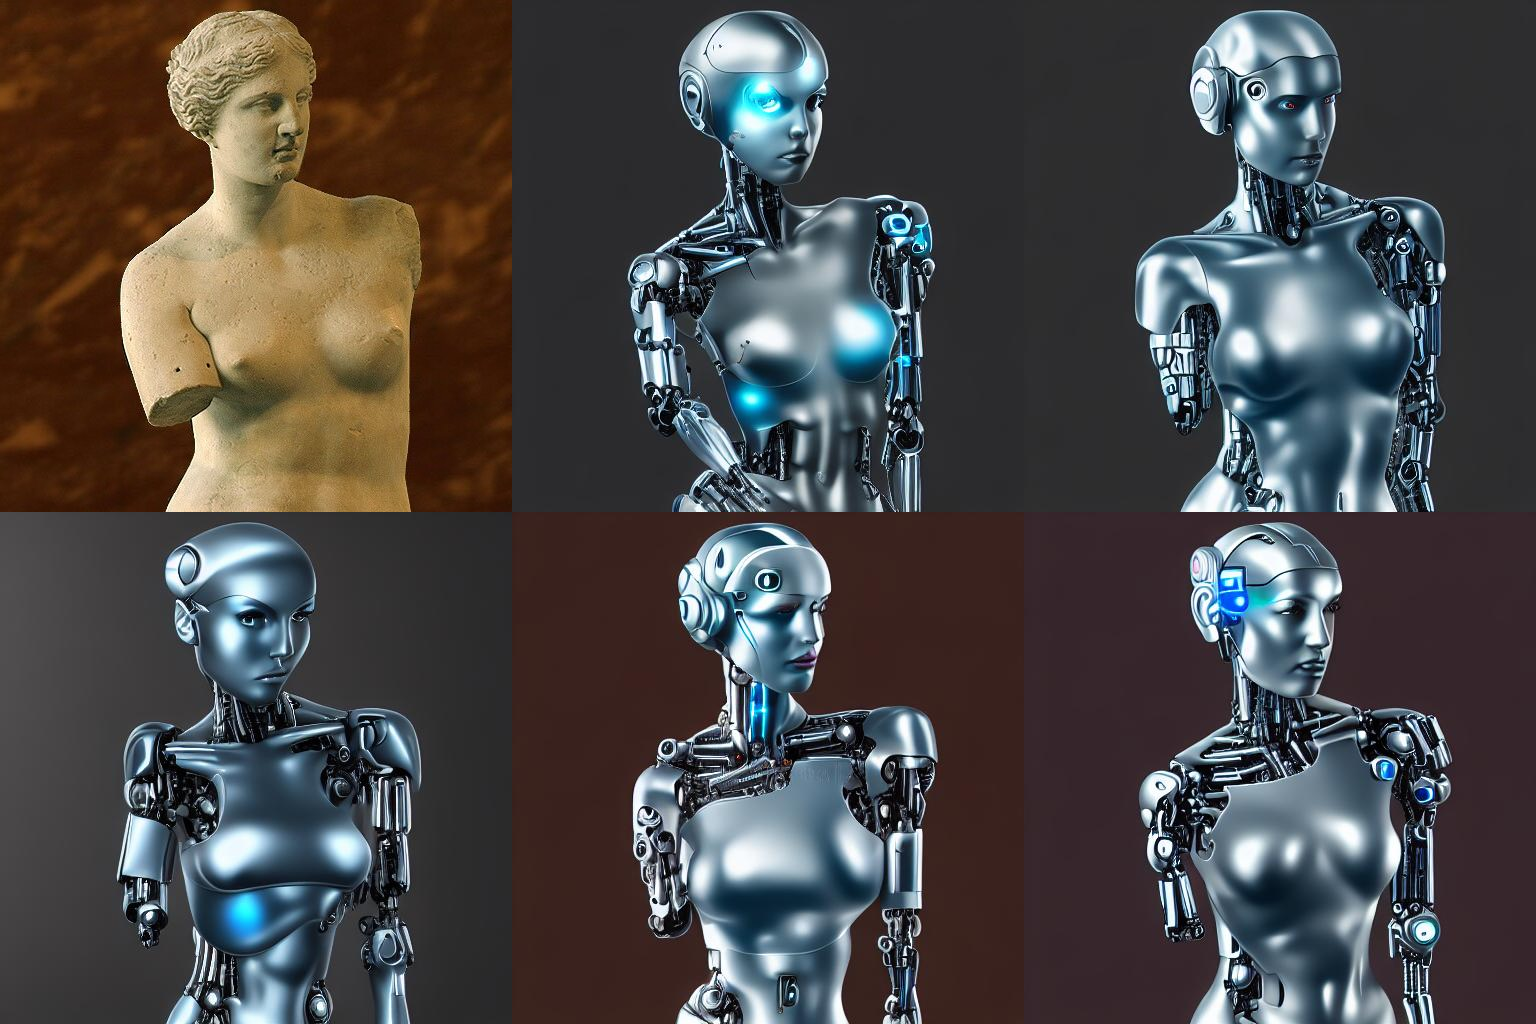

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import base64

def _stringToPil(
    img_string: str
    ):
    is_data_url = True if len(img_string.split(",")) > 1 else False
    
    if is_data_url:
        base64string = img_string.split(",")[1]
    else:
        base64string = img_string

    img = Image.open(BytesIO(base64.b64decode(base64string,
         validate=True))).convert("RGB")
    return img

def image_grid(imgs, rows, cols):

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

imgs = []
imgs.append(_stringToPil(base64_string))
for i, sample in enumerate(res):
    imgs.append(_stringToPil(sample["image"]))
    
    
image_grid(imgs, 2, 3)